In [1]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
import numpy as np
import numpy.random as r
import matplotlib.pyplot as plt 
import pandas as pd

**Preprocessing the data:**

In [2]:
df = pd.read_csv('diamonds.csv', na_values = ['unknown'])
col = df.columns.values.tolist()[1:]

# Columns with NaN content > null_threshold will not be used as features
null_threshold = 0.0001

corrupt_col = []
for i in col:
  if (df[i].isna().sum()/len(df) > null_threshold):
    corrupt_col.append(i)

for i in corrupt_col:
  df = df.drop(i, axis=1)

col = df.columns.values.tolist()[1:]

# feature data frames with one-hot encoding to concatinate once encoded
cut = pd.get_dummies(df.cut, prefix='cut')
carat_weight = pd.DataFrame(df['carat_weight'])
lab = pd.get_dummies(df.lab, prefix='lab')
depth_percent = pd.DataFrame(df['depth_percent'])
table_percent = pd.DataFrame(df['table_percent'])
meas_length = pd.DataFrame(df['meas_length'])
meas_width = pd.DataFrame(df['meas_width'])
meas_depth = pd.DataFrame(df['meas_depth'])
total_sales_price = pd.DataFrame(df['total_sales_price'])

# convert clarity to int 0-10
clarity = pd.DataFrame(df['clarity'])
for i in range(len(clarity)):
  grade = ['I3', 'I2', 'I1', 'IF', 'SI3', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1']
  clarity['clarity'][i] = grade.index(clarity['clarity'][i])

# convert symmetry to int 0-4
symmetry = pd.DataFrame(df['symmetry'])
for i in range(len(symmetry)):
  sym = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
  symmetry['symmetry'][i] = sym.index(symmetry['symmetry'][i])

# convert polish to int 0-4
polish = pd.DataFrame(df['polish'])
for i in range(len(polish)):
  pol = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
  polish['polish'][i] = pol.index(polish['polish'][i])

# combining features into cleaned dataframe for regression
frames = [clarity, carat_weight, lab, symmetry, polish, depth_percent, table_percent, meas_length, meas_width, meas_depth, total_sales_price]
clean_regression = pd.concat(frames, axis=1)

# update list of column names
col = clean_regression.columns.values.tolist()[1:]

# updating total_sales_price for classiffication(i.e. 1 if price > x, otherwise 0 for some threshold x)
price_threshold = 250

clean_classification = clean_regression.copy()

for i in range(len(clean_classification)):
  if clean_classification['total_sales_price'][i] > price_threshold:
    clean_classification['total_sales_price'][i] = 1
  else:
    clean_classification['total_sales_price'][i] = 0

<ipython-input-2-54df3467acd3>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_classification['total_sales_price'][i] = 0
<ipython-input-2-54df3467acd3>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_classification['total_sales_price'][i] = 1


In [3]:
# converts 2d numpy array of value to array of vectors
# to use one-verses-all encoding for every 10th percetnile
# of diamond prices present in the dataset - **modified from HW5**
def convert_y_to_vect(y):
    blocks = 10
    block_size = len(y) // blocks
    index = []
    for i in range(blocks):
      index.append(y[i*block_size][0])
    y = y[0:(len(y)-len(y)%blocks)]
    for i in range(len(y)):
      for j in range(len(index)):
            if j == len(index)-1:
              y[i] = j
            else:
              if y[i] > index[j] and y[i] <= index[j+1]:
                y[i] = j
                break
              else:
                continue
    return y
    # blocks = 10
    # block_size = len(y) // blocks
    # index = []
    # for i in range(blocks):
    #   index.append(y[i*block_size][0])
    # y = y[0:(len(y)-len(y)%blocks)]
    # y_vect = np.zeros((len(y), blocks))
    # for i in range(len(y)):
    #   for j in range(len(index)):
    #     if j == len(index)-1:
    #       y_vect[i][j] = 1
    #     else:
    #       if y[i] >= index[j] and y[i] <= index[j+1]:
    #         y_vect[i][j] = 1
    #         break
    #       else:
    #         continue
    # return y_vect

In [4]:
X = np.zeros((len(clean_regression), 1))
columns =  clean_regression.columns.to_list()

for i in columns:
  temp = clean_regression[i].to_numpy().reshape(len(clean_regression), 1)
  X = np.concatenate((X, temp), 1)

X = np.delete(X, 13, axis=1)
X = np.delete(X, 0, axis=1)

y = clean_regression['total_sales_price'].to_numpy().reshape(len(clean_regression), 1)

for i in range(len(y)%10):
  X = X[:-1,:]

y = convert_y_to_vect(y)

X_scale = StandardScaler()
X = X_scale.fit_transform(X)

# shuffle
r_indexes = np.arange(len(X))
np.random.shuffle(r_indexes)

X = X[r_indexes]
y = y[r_indexes]

# take certain amount of examples
X = X[:5000]
y = y[:5000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [5]:
# sigmoid and derivative of sigmoid - **from HW5**
def f(z):
    return 1 / (1 + np.exp(-z))
    

def f_deriv(z):
    return f(z) * (1 - f(z))

In [6]:
# initializing weights, W, and biases, b - **from HW5**
def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

In [7]:
# initalize gradient vector of W and b with same size, set to zero - **from HW5**
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

In [10]:
# dict to hold a and z values for all layers - **from HW5**
def feed_forward(x, W, b):
    a = {1: x}
    z = { }
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

In [11]:
# delta calculator functions - **from HW5**
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    out = -(y-a_out) * f_deriv(z_out) 
    # print(out.shape)
    return out 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    out = np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)
    # print(out.shape)
    return out

In [9]:
# Back propogation - **from HW5**
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [12]:
# NN parameter
nn_structure = [12, 10, 10]
iterations = 5000

In [13]:
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_train, iterations)

Starting gradient descent for 5000 iterations
Iteration 0 of 5000
Iteration 1000 of 5000
Iteration 2000 of 5000
Iteration 3000 of 5000
Iteration 4000 of 5000


In [ ]:
clean_regression.tail(5)

In [14]:
# test accuracy of model
y_pred = predict_y(W, b, X_test, 3)
accuracy = accuracy_score(y_test, y_pred) * 100
print('Prediction accuracy is {}%'.format(accuracy))

Prediction accuracy is 10.05%


In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

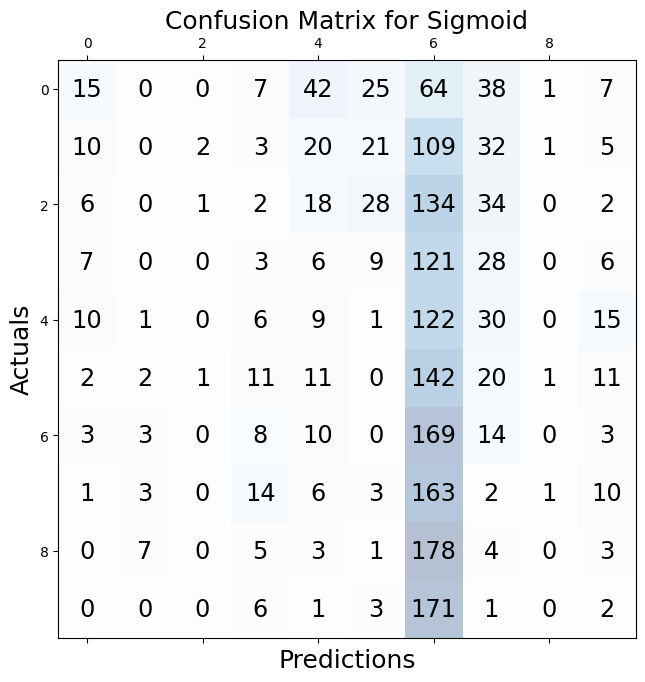

In [21]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Sigmoid', fontsize=18)
plt.show()

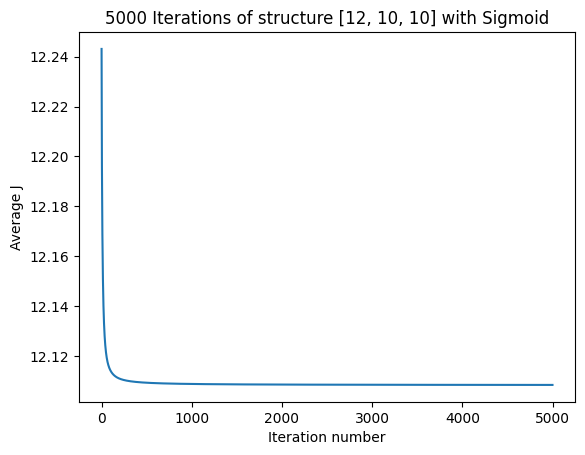

In [22]:
# plot the avg_cost_func - **modified from HW5**
plt.plot(avg_cost_func)
plt.title('{} Iterations of structure {} with Sigmoid'.format(iterations, nn_structure))
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()